In [1]:
import numpy as np
print(np.__version__)
print(np.__file__)
!pip install seaborn
!pip install scikit-learn


2.3.1
C:\Users\91950\miniconda3\Lib\site-packages\numpy\__init__.py


In [2]:
!pip install nltk

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn

import re
import string
import nltk


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Download required resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords',quiet=True)

# Define tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [90]:
data= pd.read_csv(r"C:\Users\91950\Downloads\Fake News Detection\train (1) (1).csv")
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Data Preproceesing

In [5]:
data.shape

(7613, 5)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
data.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
# location has almost half rows missing
#data['keyword'].fillna("None", inplace=True) #FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
# data.fillna({'keyword':"None"}, inplace=True)
data['keyword']=data['keyword'].fillna("None")

In [9]:
data['keyword'].isnull().sum()

np.int64(0)

In [10]:
data['location']=data['location'].fillna("Unknown")

In [11]:
data.isnull().sum() 

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

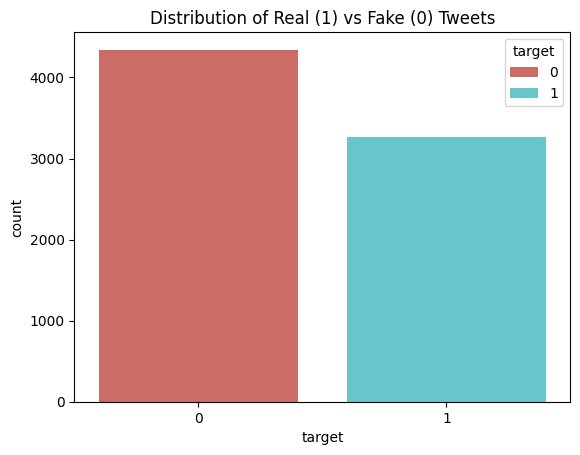

In [12]:
sns.countplot(x='target',data=data,hue='target', palette='hls')
plt.title("Distribution of Real (1) vs Fake (0) Tweets")
plt.show()


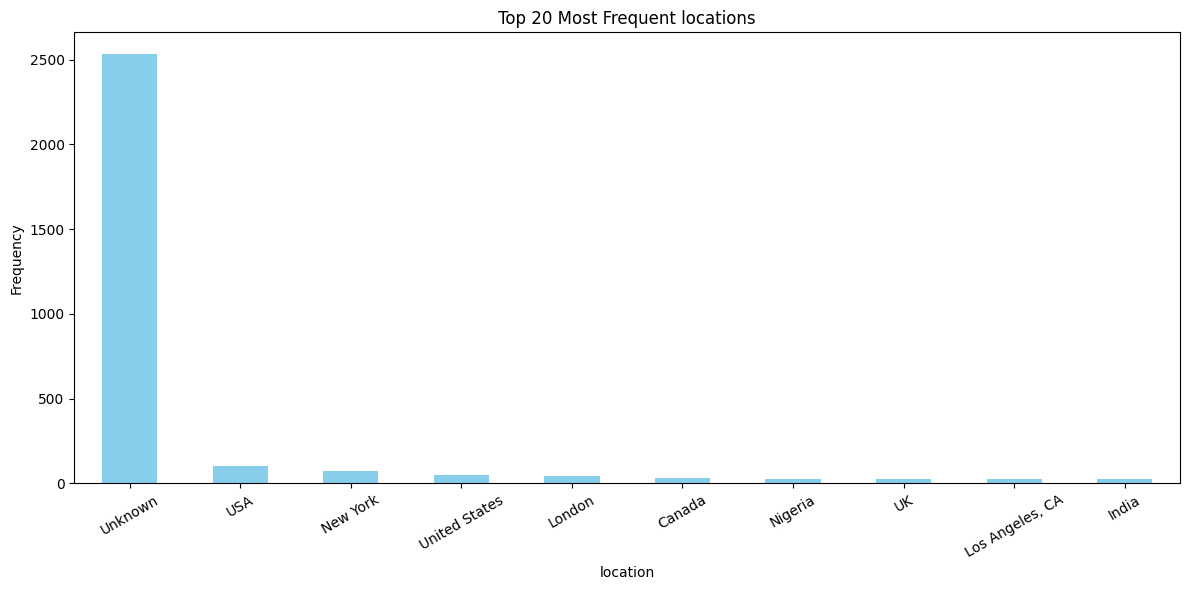

In [13]:
# Plot top 20 keywords
plt.figure(figsize=(12,6))
data['location'].value_counts().nlargest(10).plot(kind='bar', color='skyblue')
plt.title("Top 20 Most Frequent locations")
plt.xlabel("location")
plt.ylabel("Frequency")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


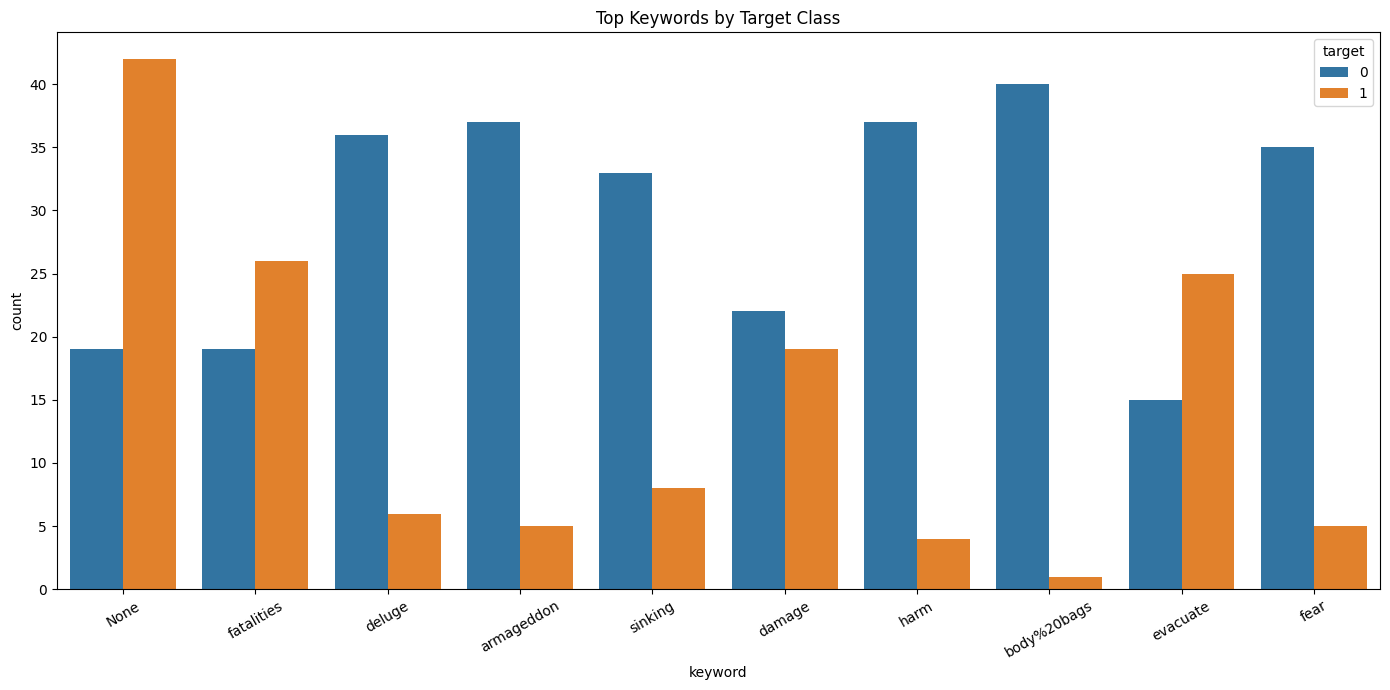

In [14]:
plt.figure(figsize=(14,7))
sns.countplot(data=data[data['keyword'].notnull()], x='keyword', hue='target', order=data['keyword'].value_counts().nlargest(10).index)
plt.title("Top Keywords by Target Class")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [15]:
data.head()

,id,keyword,location,text,target
0,1,None,Unknown,Our Deeds are the Reason of this #earthquake M...,1
1,4,None,Unknown,Forest fire near La Ronge Sask. Canada,1
2,5,None,Unknown,All residents asked to 'shelter in place' are ...,1
3,6,None,Unknown,"13,000 people receive #wildfires evacuation or...",1
4,7,None,Unknown,Just got sent this photo from Ruby #Alaska as ...,1


In [16]:
data['text']

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [17]:
# Append keyword and location into one text column
data['combined_text'] = data['keyword'] + " " + data['location'] + " " + data['text']
data['combined_text'] 

0       None Unknown Our Deeds are the Reason of this ...
1       None Unknown Forest fire near La Ronge Sask. C...
2       None Unknown All residents asked to 'shelter i...
3       None Unknown 13,000 people receive #wildfires ...
4       None Unknown Just got sent this photo from Rub...
                              ...                        
7608    None Unknown Two giant cranes holding a bridge...
7609    None Unknown @aria_ahrary @TheTawniest The out...
7610    None Unknown M1.94 [01:04 UTC]?5km S of Volcan...
7611    None Unknown Police investigating after an e-b...
7612    None Unknown The Latest: More Homes Razed by N...
Name: combined_text, Length: 7613, dtype: object

## Text Preprocessing

In [18]:

# Preprocessing function
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove URLs, mentions, hashtags, punctuation, and numbers
    text = re.sub(r"http\S+|www\S+", "", text)              # Remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)                   # Remove mentions/hashtags
    text = re.sub(r"\d+", "", text)                         # Remove digits
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    text = re.sub(r"[^a-z\s]", "", text)                    # Remove non-alphabetic chars
    text = re.sub(r"\s+", " ", text).strip()                # Remove extra spaces
    
    # 3. Tokenize
    tokens = word_tokenize(text)
    
    # 4. Remove stopwords & short tokens
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # 5. Stemming
    tokens = [stemmer.stem(word) for word in tokens]
    
    return " ".join(tokens)  # Return cleaned string for vectorizer

# Apply to your dataset
data['clean_text'] = data['combined_text'].apply(preprocess_text)

In [19]:
data['clean_text']

0               none unknown deed reason may allah forgiv
1          none unknown forest fire near rong sask canada
2       none unknown resid ask shelter place notifi of...
3        none unknown peopl receiv evacu order california
4       none unknown got sent photo rubi smoke pour sc...
                              ...                        
7608    none unknown two giant crane hold bridg collap...
7609    none unknown control wild fire california even...
7610                    none unknown utckm volcano hawaii
7611    none unknown polic investig ebik collid car li...
7612    none unknown latest home raze northern califor...
Name: clean_text, Length: 7613, dtype: object

In [20]:
data

,id,keyword,location,text,target,combined_text,clean_text
0,1,None,Unknown,Our Deeds are the Reason of this #earthquake M...,1,None Unknown Our Deeds are the Reason of this ...,none unknown deed reason may allah forgiv
1,4,None,Unknown,Forest fire near La Ronge Sask. Canada,1,None Unknown Forest fire near La Ronge Sask. C...,none unknown forest fire near rong sask canada
2,5,None,Unknown,All residents asked to 'shelter in place' are ...,1,None Unknown All residents asked to 'shelter i...,none unknown resid ask shelter place notifi of...
3,6,None,Unknown,"13,000 people receive #wildfires evacuation or...",1,"None Unknown 13,000 people receive #wildfires ...",none unknown peopl receiv evacu order california
4,7,None,Unknown,Just got sent this photo from Ruby #Alaska as ...,1,None Unknown Just got sent this photo from Rub...,none unknown got sent photo rubi smoke pour sc...
...,...,...,...,...,...,...,...
7608,10869,None,Unknown,Two giant cranes holding a bridge collapse int...,1,None Unknown Two giant cranes holding a bridge...,none unknown two giant crane hold bridg collap...
7609,10870,None,Unknown,@aria_ahrary @TheTawniest The out of control w...,1,None Unknown @aria_ahrary @TheTawniest The out...,none unknown control wild fire california even...
7610,10871,None,Unknown,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,None Unknown M1.94 [01:04 UTC]?5km S of Volcan...,none unknown utckm volcano hawaii
7611,10872,None,Unknown,Police investigating after an e-bike collided ...,1,None Unknown Police investigating after an e-b...,none unknown polic investig ebik collid car li...


In [21]:
data= data.drop(["text",'combined_text','id'],axis=1)
data

,keyword,location,target,clean_text
0,None,Unknown,1,none unknown deed reason may allah forgiv
1,None,Unknown,1,none unknown forest fire near rong sask canada
2,None,Unknown,1,none unknown resid ask shelter place notifi of...
3,None,Unknown,1,none unknown peopl receiv evacu order california
4,None,Unknown,1,none unknown got sent photo rubi smoke pour sc...
...,...,...,...,...
7608,None,Unknown,1,none unknown two giant crane hold bridg collap...
7609,None,Unknown,1,none unknown control wild fire california even...
7610,None,Unknown,1,none unknown utckm volcano hawaii
7611,None,Unknown,1,none unknown polic investig ebik collid car li...


In [22]:
data= data.drop(["keyword",'location'],axis=1)
data

,target,clean_text
0,1,none unknown deed reason may allah forgiv
1,1,none unknown forest fire near rong sask canada
2,1,none unknown resid ask shelter place notifi of...
3,1,none unknown peopl receiv evacu order california
4,1,none unknown got sent photo rubi smoke pour sc...
...,...,...
7608,1,none unknown two giant crane hold bridg collap...
7609,1,none unknown control wild fire california even...
7610,1,none unknown utckm volcano hawaii
7611,1,none unknown polic investig ebik collid car li...


### Visualize the most frequently used words with wordcloud

In [23]:
!pip install wordcloud

In [24]:
from wordcloud import WordCloud

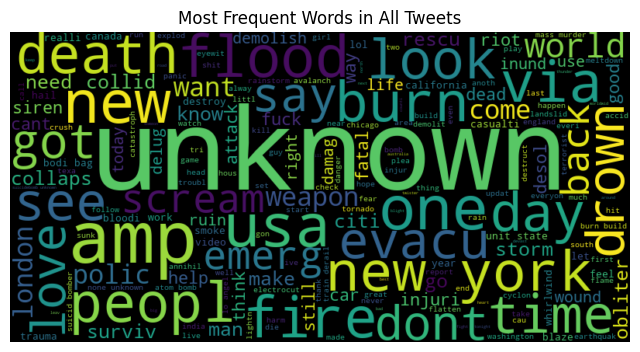

In [25]:
# Join all cleaned text into one string
all_words = ' '.join(data['clean_text'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_words)

# Plot it
plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in All Tweets")
plt.show()

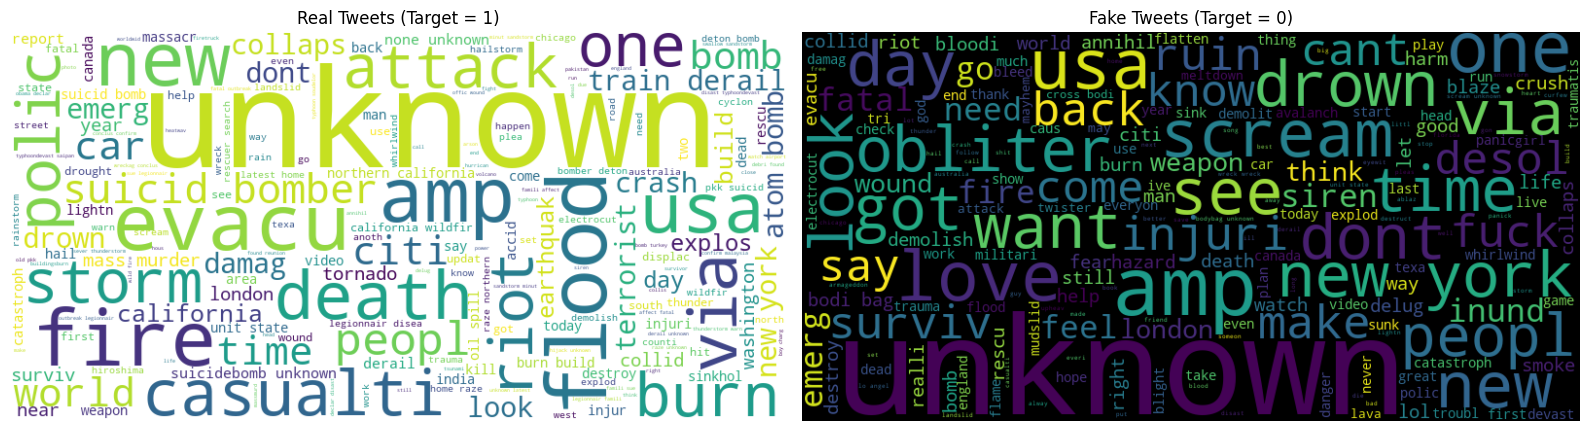

In [26]:
# For Real Tweets (target = 1)
real_words = ' '.join(data[data['target'] == 1]['clean_text'])
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_words)

# For Fake Tweets (target = 0)
fake_words = ' '.join(data[data['target'] == 0]['clean_text'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_words)

# Plot side by side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title("Real Tweets (Target = 1)")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Fake Tweets (Target = 0)")

plt.tight_layout()
plt.show()


## Feature Extraction

In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#### Bag of Words:

In [28]:
bow_vectorizer = CountVectorizer(max_features=5000)  # limit to top 5000 words
X_bow = bow_vectorizer.fit_transform(data['clean_text']).toarray()
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(7613, 5000))

#### TF-IDF:

In [29]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(data['clean_text']).toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(7613, 5000))

In [30]:
y = data['target']


In [31]:
# !pip install gensim

### Install and Load Pretrained Word2Vec Model

In [32]:
# import gensim

In [33]:
# import gensim.downloader as api

# # This will download and load Google's Word2Vec pretrained model (300 dimensions)
# w2v_model = api.load("word2vec-google-news-300")


In [34]:
data['tokens'] = data['clean_text'].apply(lambda x: x.split())
data['tokens']

0       [none, unknown, deed, reason, may, allah, forgiv]
1       [none, unknown, forest, fire, near, rong, sask...
2       [none, unknown, resid, ask, shelter, place, no...
3       [none, unknown, peopl, receiv, evacu, order, c...
4       [none, unknown, got, sent, photo, rubi, smoke,...
                              ...                        
7608    [none, unknown, two, giant, crane, hold, bridg...
7609    [none, unknown, control, wild, fire, californi...
7610              [none, unknown, utckm, volcano, hawaii]
7611    [none, unknown, polic, investig, ebik, collid,...
7612    [none, unknown, latest, home, raze, northern, ...
Name: tokens, Length: 7613, dtype: object

In [35]:
# def get_avg_w2v(tokens, model, dim=300):
#     valid_words = [word for word in tokens if word in model]
#     if valid_words:
#         return np.mean([model[word] for word in valid_words], axis=0)
#     else:
#         return np.zeros(dim)

# X_w2v = np.vstack(df['tokens'].apply(lambda x: get_avg_w2v(x, w2v_model)))

### Split for validation
## X_tfidf-based model

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### 1. Logistic Regression

Logistic Regression
Accuracy: 0.799080761654629
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       874
           1       0.80      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



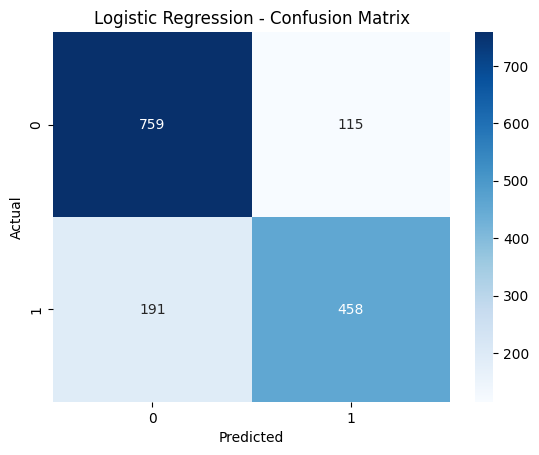

In [38]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_val)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_val, y_pred_lr))
print(classification_report(y_val, y_pred_lr))

sns.heatmap(confusion_matrix(y_val, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 2. Support Vector Machine (SVM)

Support Vector Machine
Accuracy: 0.7925147734734077
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       874
           1       0.78      0.71      0.75       649

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523



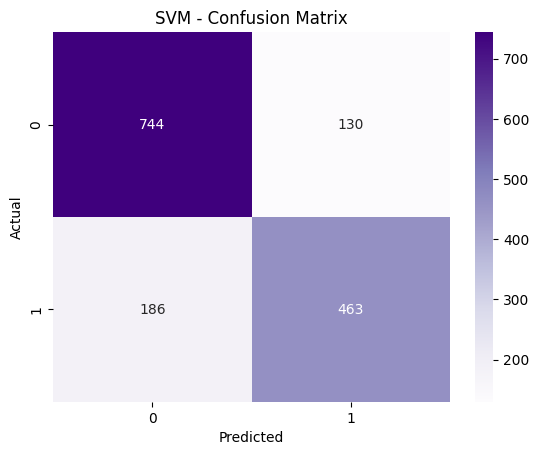

In [39]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_val)

print("Support Vector Machine")
print("Accuracy:", accuracy_score(y_val, y_pred_svm))
print(classification_report(y_val, y_pred_svm))

sns.heatmap(confusion_matrix(y_val, y_pred_svm), annot=True, fmt='d', cmap='Purples')
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 3. Naive Bayes (Multinomial)


Naive Bayes
Accuracy: 0.7944845699277742
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       874
           1       0.80      0.69      0.74       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.79      0.79      1523



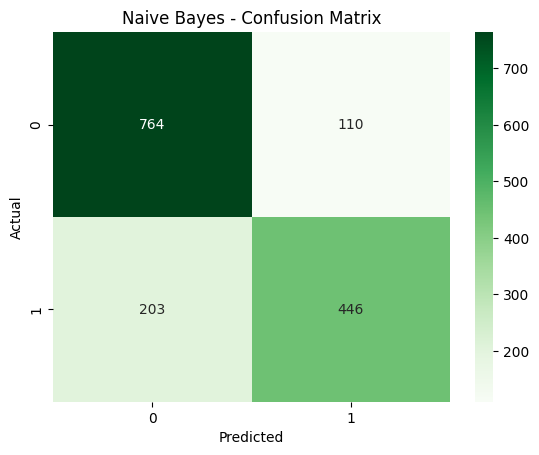

In [40]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_val)

print("Naive Bayes")
print("Accuracy:", accuracy_score(y_val, y_pred_nb))
print(classification_report(y_val, y_pred_nb))

sns.heatmap(confusion_matrix(y_val, y_pred_nb), annot=True, fmt='d', cmap='Greens')
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [41]:
from sklearn.metrics import f1_score

print("Summary:")
print("Logistic Regression F1:", round(f1_score(y_val, y_pred_lr),4))
print("SVM F1:", round(f1_score(y_val, y_pred_svm),4))
print("Naive Bayes F1:", round(f1_score(y_val, y_pred_nb),4))

Summary:
Logistic Regression F1: 0.7496
SVM F1: 0.7456
Naive Bayes F1: 0.7402


##### Since Naive Bayes achieved substantially lower accuracy and ROC-AUC, we did not proceed with hyperparameter tuning, and focused on optimizing Logistic Regression and SVM."

### Hyperparameter Tuning Plan (TF-IDF Features)
#### 1. Logistic Regression

In [56]:
from sklearn.model_selection import RandomizedSearchCV


param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs']
}
rand_lr = RandomizedSearchCV(LogisticRegression(max_iter=1000),
                             param_distributions=param_grid_lr,
                             n_iter=5, cv=5, scoring='f1', verbose=1, n_jobs=1)
rand_lr.fit(X_train, y_train)
# Best model
print("Best LR Parameters:", rand_lr.best_params_)

# Evaluate
y_pred_rand_lr= rand_lr.predict(X_val)
best_logreg = rand_lr.best_estimator_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best LR Parameters: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}


### 2. Support Vector Machine (SVM)



In [58]:

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10]}
grid_linear_svc = GridSearchCV(LinearSVC(max_iter=5000), param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid_linear_svc.fit(X_train, y_train)

print("Best LinearSVC parameters:", grid_linear_svc.best_params_)
y_pred_grid_svm = grid_linear_svc.predict(X_val)
best_svm = grid_linear_svc.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best LinearSVC parameters: {'C': 1}


In [59]:
print("Tuned Logistic F1:", round(f1_score(y_val, y_pred_rand_lr),4))
print("Tuned SVM F1:",  round(f1_score(y_val, y_pred_grid_svm),4))

Tuned Logistic F1: 0.7473
Tuned SVM F1: 0.7242


## Word2Vec based Model
##### For Word2Vec: Use only Logistic Regression and SVM- MultinomialNB expects non-negative integer counts (so won’t work well with Word2Vec).

In [45]:
# X_train, X_val, y_train, y_val = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

#### 1. Logistic Regression with Word2Vec

In [46]:
# lr_model = LogisticRegression(max_iter=1000)
# lr_model.fit(X_train, y_train)
# y_pred_lr = lr_model.predict(X_val)

# print("Logistic Regression (Word2Vec)")
# print("Accuracy:", accuracy_score(y_val, y_pred_lr))
# print(classification_report(y_val, y_pred_lr))

# sns.heatmap(confusion_matrix(y_val, y_pred_lr), annot=True, fmt='d', cmap='Blues')
# plt.title("Logistic Regression - Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()

#### 2. SVM (Linear Kernel) with Word2Vec

In [47]:
# svm_model = SVC(kernel='linear')
# svm_model.fit(X_train, y_train)
# y_pred_svm = svm_model.predict(X_val)

# print("SVM (Word2Vec)")
# print("Accuracy:", accuracy_score(y_val, y_pred_svm))
# print(classification_report(y_val, y_pred_svm))

# sns.heatmap(confusion_matrix(y_val, y_pred_svm), annot=True, fmt='d', cmap='Purples')
# plt.title("SVM - Confusion Matrix")
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.show()



In [48]:
# print("F1 Score - Logistic (TF-IDF):", f1_score(y_val, y_pred_lr_tfidf))
# print("F1 Score - Logistic (Word2Vec):", f1_score(y_val, y_pred_lr))

### Hyperparamter Tuning- with Word2Vec

In [49]:
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

##### RandomizedSearchCV for Logistic Regression + Word2Vec

In [50]:

# param_dist_lr = {
#     'C': [0.01, 0.1, 1, 10, 100],
#     'penalty': ['l2'],
#     'solver': ['liblinear', 'lbfgs']
# }

# rand_lr_w2v = RandomizedSearchCV(
#     estimator=LogisticRegression(max_iter=1000),
#     param_distributions=param_dist_lr,
#     n_iter=5,
#     cv=5,
#     scoring='f1',
#     verbose=1,
#     n_jobs=1,
#     random_state=42
# )

# rand_lr_w2v.fit(X_train, y_train)
# print("Best Word2Vec-LR Params:", rand_lr_w2v.best_params_)

# # Predict and evaluate
# y_pred_lr_w2v = rand_lr_w2v.predict(X_val)

# print("Accuracy:", accuracy_score(y_val, y_pred_lr_w2v))
# print(classification_report(y_val, y_pred_lr_w2v))


#### RandomizedSearchCV for SVM + Word2Vec

In [51]:
# param_dist_svm = {
#     'C': [0.1, 1, 10, 100],
#     'kernel': ['linear', 'rbf'],
#     'gamma': ['scale', 'auto']
# }

# rand_svm_w2v = RandomizedSearchCV(
#     estimator=SVC(),
#     param_distributions=param_dist_svm,
#     n_iter=5,  # Number of parameter combinations to try
#     cv=5,
#     scoring='f1',
#     verbose=1,
#     n_jobs=1,
#     random_state=42
# )

# rand_svm_w2v.fit(X_train, y_train)
# print("Best Word2Vec-SVM Params:", rand_svm_w2v.best_params_)

# # Predict and evaluate
# y_pred_svm_w2v = rand_svm_w2v.predict(X_val)

# from sklearn.metrics import accuracy_score, classification_report
# print("Accuracy:", accuracy_score(y_val, y_pred_svm_w2v))
# print(classification_report(y_val, y_pred_svm_w2v))

### Compare performance metrics



In [60]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc

models = {
    "Logistic Regression": best_logreg,   # replace with your tuned model variable
    "SVM": best_svm,
    # "Naive Bayes": best_nb
}

# Store metrics
metrics = {}

for name, model in models.items():
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:,1] if hasattr(model, "predict_proba") else model.decision_function(X_val)
    
    report = classification_report(y_val, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_val, y_proba)
    
    metrics[name] = {
        "accuracy": report["accuracy"],
        "precision": report["1"]["precision"],
        "recall": report["1"]["recall"],
        "f1-score": report["1"]["f1-score"],
        "roc_auc": roc_auc
    }

# Display neatly
import pandas as pd
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


                     accuracy  precision    recall  f1-score   roc_auc
Logistic Regression  0.797111   0.796167  0.704160  0.747343  0.850528
SVM                  0.773473   0.752492  0.697997  0.724221  0.839238


### Plot ROC curves

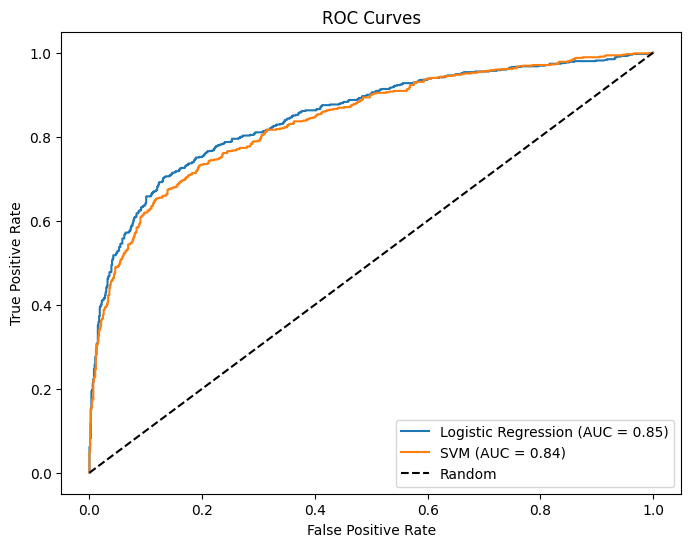

In [61]:
plt.figure(figsize=(8,6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_val)[:,1]
    else:
        y_scores = model.decision_function(X_val)
        
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_val, y_scores):.2f})")

plt.plot([0,1], [0,1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


## Interpretation of ROC Curves

The ROC curve compares the true positive rate against the false positive rate at various thresholds.

- Our Logistic Regression model achieved an ROC-AUC of **0.85**, which shows it has good ability to distinguish between real disaster tweets and non-disaster tweets.
- The SVM model achieved an ROC-AUC of **0.84**, which is slightly lower but still shows good discriminative power.
- Both curves stay well above the diagonal "random" line, indicating that the models are performing significantly better than random guessing.

This visualization supports our decision to choose Logistic Regression as the final model, as it slightly outperforms SVM in ROC-AUC.


### Plot Precision-Recall curves

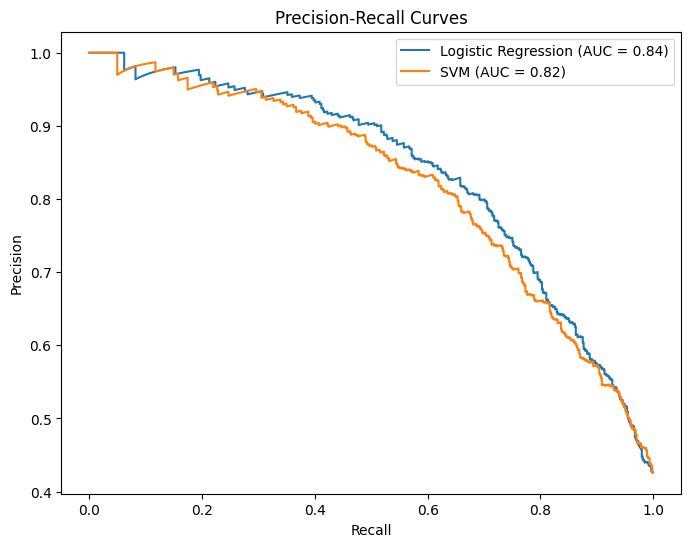

In [62]:
plt.figure(figsize=(8,6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_val)[:,1]
    else:
        y_scores = model.decision_function(X_val)
        
    precision, recall, _ = precision_recall_curve(y_val, y_scores)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{name} (AUC = {pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()


## Interpretation of Precision-Recall Curves

The Precision-Recall curve helps evaluate model performance on imbalanced datasets by showing the trade-off between precision and recall.

- Logistic Regression achieved an AUC of **0.84**, while SVM achieved an AUC of **0.82**.
- The Logistic Regression curve stays higher than SVM across most recall values, indicating that it generally maintains higher precision at similar levels of recall.

This curve also confirms that Logistic Regression is slightly better at balancing false positives and false negatives, which is important in fake news detection.


### Visualize confusion matrices

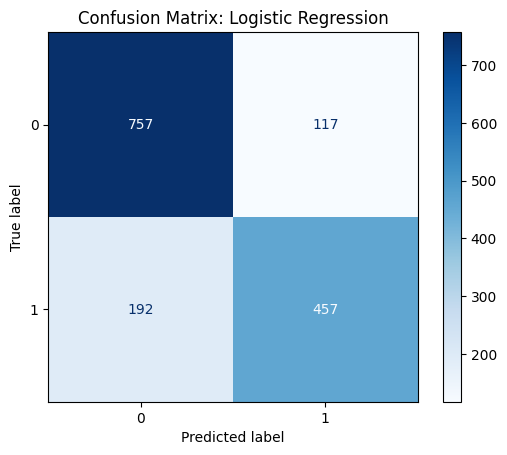

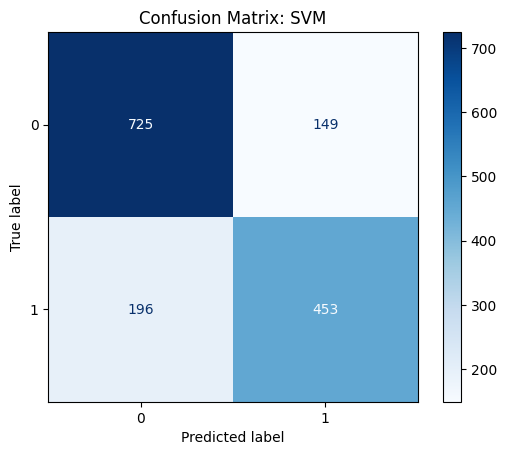

In [63]:
from sklearn.metrics import ConfusionMatrixDisplay

for name, model in models.items():
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.show()


**Observations:**
- Both models correctly identify a large number of real disaster tweets (TP ≈ 450).
- Logistic Regression has fewer false positives (117 vs 149) than SVM, which means it makes fewer mistakes by predicting disaster when it’s not.
- Logistic Regression also has slightly fewer false negatives (192 vs 196), so it misses slightly fewer actual disaster tweets.
- Overall, Logistic Regression shows a better balance between false positives and false negatives compared to SVM.

These findings align with the ROC and Precision-Recall curves, supporting the choice of Logistic Regression as the final model.

In [64]:
from sklearn.metrics import classification_report, roc_auc_score

# Logistic Regression
y_pred_lr = best_logreg.predict(X_val)
y_scores_lr = best_logreg.predict_proba(X_val)[:,1]
roc_auc_lr = roc_auc_score(y_val, y_scores_lr)
report_lr = classification_report(y_val, y_pred_lr)

# SVM
y_pred_svm = best_svm.predict(X_val)
# LinearSVC doesn’t have predict_proba, so use decision_function
y_scores_svm = best_svm.decision_function(X_val)
roc_auc_svm = roc_auc_score(y_val, y_scores_svm)
report_svm = classification_report(y_val, y_pred_svm)

print("=== Logistic Regression ===")
print(report_lr)
print("ROC-AUC:", roc_auc_lr)

print("\n=== SVM (LinearSVC) ===")
print(report_svm)
print("ROC-AUC:", roc_auc_svm)


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       874
           1       0.80      0.70      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

ROC-AUC: 0.8505278319400029

=== SVM (LinearSVC) ===
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       874
           1       0.75      0.70      0.72       649

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.77      1523
weighted avg       0.77      0.77      0.77      1523

ROC-AUC: 0.8392377993956552


### Choosing the Final Model: Why Logistic Regression

After training and evaluating three models—Logistic Regression, LinearSVC (SVM), and Naive Bayes—on our validation set, we compared their performance metrics, including accuracy, F1-score, and ROC-AUC.

- **Logistic Regression** achieved the highest accuracy (0.80) and F1-score for the disaster class (0.75), as well as the highest ROC-AUC (0.85).
- **LinearSVC (SVM)** performed slightly worse, with lower accuracy (0.77) and ROC-AUC (0.84).
- **Naive Bayes** was used as a baseline model and performed worse overall, so we did not invest in hyperparameter tuning for it.

Logistic Regression also provides **probabilistic outputs** via `predict_proba`, which is useful for further analysis like adjusting decision thresholds, interpreting model confidence, and plotting ROC and Precision-Recall curves.

Considering both the quantitative metrics and practical advantages, **we selected Logistic Regression as our final model** for predicting fake news on the test data.


### Display misclassified examples



In [66]:
from sklearn.model_selection import train_test_split

# Split vectorized features
X = X_tfidf
y = data['target']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Also keep the raw text
texts = data['clean_text']

X_train_texts, X_val_texts, _, _ = train_test_split(
    texts, y, test_size=0.2, random_state=42
)


In [67]:
chosen_model = best_logreg
y_pred = chosen_model.predict(X_val)

misclassified_idx = (y_pred != y_val)

import pandas as pd

misclassified = pd.DataFrame({
    "Text": X_val_texts[misclassified_idx].values,
    "True Label": y_val[misclassified_idx].values,
    "Predicted": y_pred[misclassified_idx]
})

print(misclassified.sample(10, random_state=42))


                                                  Text  True Label  Predicted
288  derail kwara nigeria use exactli nation assemb...           0          1
9    surviv mumbai maharashtra miracl mankind survi...           1          0
57   derail washington happi one hurt train derail ...           1          0
60   sinkhol atlantaish talk goz fantast interest f...           0          1
25                                   bomb itd bomb guy           0          1
63   heatwav unknown chilli heat wave dorito never ...           0          1
92     devast unknown amp devast amp indianperpetr amp           1          0
184                              flood van buren didnt           0          1
244  threat bianlaguna meek mill respond drake ovo ...           1          0
46                volcano cleveland volcano bowl drink           1          0


##  Analysis of Misclassified Tweets

We examined a few tweets that our model misclassified.  
Common patterns among these failures include:

- The presence of strong disaster-related words (e.g., “bomb”, “flood”, “derail”) in non-disaster contexts, which leads to false positives.
- Tweets with real disaster references but written abstractly, humorously, or with mixed sentiment, which leads to false negatives.
- Ambiguous or very short tweets without clear context, making it hard for the model to decide.

These patterns show that while TF-IDF and traditional machine learning models work reasonably well, they struggle with:
- Irony, humor, and sarcasm.
- Tweets using disaster words in figurative or cultural contexts.
- Lack of surrounding context beyond the single tweet.

This analysis highlights the limitations of keyword-based features and the potential value of more advanced models (e.g., deep learning or embeddings) to capture context better.


### Load Test Data

In [69]:
test_df= pd.read_csv(r"C:\Users\91950\Downloads\Fake News Detection\test (1).csv")

In [70]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Preprocess Data

In [75]:
test_df['keyword'] = test_df['keyword'].fillna('None')
test_df['location'] = test_df['location'].fillna('Unknown')


In [76]:
test_df['combined_text'] = test_df['keyword'] + " " + test_df['location'] + " " + test_df['text']
test_df['combined_text']
test_df


,id,keyword,location,text,combined_text
0,0,None,Unknown,Just happened a terrible car crash,None Unknown Just happened a terrible car crash
1,2,None,Unknown,"Heard about #earthquake is different cities, s...",None Unknown Heard about #earthquake is differ...
2,3,None,Unknown,"there is a forest fire at spot pond, geese are...",None Unknown there is a forest fire at spot po...
3,9,None,Unknown,Apocalypse lighting. #Spokane #wildfires,None Unknown Apocalypse lighting. #Spokane #wi...
4,11,None,Unknown,Typhoon Soudelor kills 28 in China and Taiwan,None Unknown Typhoon Soudelor kills 28 in Chin...
...,...,...,...,...,...
3258,10861,None,Unknown,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,None Unknown EARTHQUAKE SAFETY LOS ANGELES ÛÒ...
3259,10865,None,Unknown,Storm in RI worse than last hurricane. My city...,None Unknown Storm in RI worse than last hurri...
3260,10868,None,Unknown,Green Line derailment in Chicago http://t.co/U...,None Unknown Green Line derailment in Chicago ...
3261,10874,None,Unknown,MEG issues Hazardous Weather Outlook (HWO) htt...,None Unknown MEG issues Hazardous Weather Outl...


In [77]:
test_df['clean_text'] = test_df['combined_text'].apply(preprocess_text)
test_df

,id,keyword,location,text,combined_text,clean_text
0,0,None,Unknown,Just happened a terrible car crash,None Unknown Just happened a terrible car crash,none unknown happen terribl car crash
1,2,None,Unknown,"Heard about #earthquake is different cities, s...",None Unknown Heard about #earthquake is differ...,none unknown heard differ citi stay safe everyon
2,3,None,Unknown,"there is a forest fire at spot pond, geese are...",None Unknown there is a forest fire at spot po...,none unknown forest fire spot pond gees flee a...
3,9,None,Unknown,Apocalypse lighting. #Spokane #wildfires,None Unknown Apocalypse lighting. #Spokane #wi...,none unknown apocalyps light
4,11,None,Unknown,Typhoon Soudelor kills 28 in China and Taiwan,None Unknown Typhoon Soudelor kills 28 in Chin...,none unknown typhoon soudelor kill china taiwan
...,...,...,...,...,...,...
3258,10861,None,Unknown,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,None Unknown EARTHQUAKE SAFETY LOS ANGELES ÛÒ...,none unknown earthquak safeti lo angel safeti ...
3259,10865,None,Unknown,Storm in RI worse than last hurricane. My city...,None Unknown Storm in RI worse than last hurri...,none unknown storm wors last hurrican cityampo...
3260,10868,None,Unknown,Green Line derailment in Chicago http://t.co/U...,None Unknown Green Line derailment in Chicago ...,none unknown green line derail chicago
3261,10874,None,Unknown,MEG issues Hazardous Weather Outlook (HWO) htt...,None Unknown MEG issues Hazardous Weather Outl...,none unknown meg issu hazard weather outlook hwo


In [78]:
test_df=test_df.drop(['keyword','location','text','combined_text'], axis=1)
test_df

,id,clean_text
0,0,none unknown happen terribl car crash
1,2,none unknown heard differ citi stay safe everyon
2,3,none unknown forest fire spot pond gees flee a...
3,9,none unknown apocalyps light
4,11,none unknown typhoon soudelor kill china taiwan
...,...,...
3258,10861,none unknown earthquak safeti lo angel safeti ...
3259,10865,none unknown storm wors last hurrican cityampo...
3260,10868,none unknown green line derail chicago
3261,10874,none unknown meg issu hazard weather outlook hwo


In [79]:
X_test_tfidf = tfidf_vectorizer.transform(test_df['clean_text'])

In [80]:
y_test_pred = best_logreg.predict(X_test_tfidf)

In [81]:
y_test_pred

array([1, 0, 1, ..., 1, 1, 1], shape=(3263,))

In [82]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': y_test_pred
})

In [83]:
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv


In [84]:
print(data['target'].value_counts())


target
0    4342
1    3271
Name: count, dtype: int64


In [85]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test_tfidf.shape)

# How many non-zero elements in test vectors?
print("Non-zero elements in test vectors:", X_test_tfidf.nnz)
print("Average non-zeros per sample:", X_test_tfidf.nnz / X_test_tfidf.shape[0])


Train shape: (6090, 5000)
Test shape: (3263, 5000)
Non-zero elements in test vectors: 26613
Average non-zeros per sample: 8.155991418939626


In [86]:
import numpy as np
print("Predicted labels count:", np.unique(y_test_pred, return_counts=True))


Predicted labels count: (array([0, 1]), array([2081, 1182]))


## Final test prediction analysis

- The training data had 57% non-disaster tweets (label 0) and 43% disaster tweets (label 1).
- The TF-IDF vectors for test data had on average ≈8 non-zero terms, which shows the text is short and sparse.
- The model predicted about 2081 zeros (≈64%) and 1182 ones (≈36%) on the test set.
- This prediction distribution is similar to the label distribution in the training data, which is expected.

